In [1]:
import sys
sys.path.append('/home/cjw/Code/DeepLearning')
import warnings
from distutils.version import LooseVersion
import os
import re 
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from autoencoder import network
from autoencoder import utils

%matplotlib inline

In [2]:
f = open('path_to_checkpoints.dat')
rawpath = f.read()
f.close()
rawpath

'/media/cjw/Data/cyto/Checkpoints\n'

In [3]:
prepath = rawpath.strip()
prepath

'/media/cjw/Data/cyto/Checkpoints'

In [4]:
f = open('checkpoints.dat')
checkpoints = list()
for line in f.readlines():
    checkpoints.append(prepath +line[1:].strip())
checkpoints
f.close()

In [5]:
datadir =  '/media/cjw/Data/cyto/mmFromTifs3/'

In [6]:
sdict= dict()

for p in checkpoints:
    try:
        file = os.path.basename(p)
        #print(file)
        m = re.findall(r'\d+', file)
        sdict[int(m[0])] = (os.path.dirname(p), p)
        #print(m)
        #LS = p.index('LS')
        
    except:
        print('LS', "not found in", p)
        

In [15]:

def get_network(size, metafile, cp_dir):
    tf.reset_default_graph()

    print(cp_dir)

    if os.path.exists(cp_dir):
        print("OK, exists")
    else:
        print("Oh no")
    #checkpoint-2018-03-02-16-31-42/'
    p_width = 32
    p_height = 32
    p_nchannels = 4
    p_channels = [0,1,3,4]
    p_nepochs = 120
    p_batchsize = 128
    p_learning_rate = 0.0002  #.00005
    p_restore = False
    p_latent_size = size
    p_droprate = 0.95
    p_stdev = .04

    enc_sizes = [(128, 3), (256, 3), (512, 3)] 
    #enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
    dec_sizes = list(reversed(enc_sizes))
    # enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
    # dec_sizes = list(reversed(enc_sizes))

    images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
    z = tf.placeholder(tf.float32, (None, p_latent_size))

    enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                          nfilters=enc_sizes)
    sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                          is_train=False, nfilters=dec_sizes)

    loss, _, _ = network.ae_loss(images, sdd)

    opt = network.model_opt(loss, p_learning_rate)

    saver = tf.train.Saver()

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(metafile) #autoencoder-64x-18660.meta')
    saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))
    return sess, enc, sdd, loss, images

In [8]:
def get_data(datadir):
    mmfiles = utils.list_mmfiles(datadir)
    print(mmfiles)

    mmdict = dict()

    n_all_images = 0
    for mmfilename in mmfiles:
    #mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
    #mmfilename = datadir + "mmplate15-1.mm"
        mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                        shape=(4,))

        header_shape = mmheader.shape
        print(header_shape, mmheader)
        xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
        xshape = tuple(xshape)
        del mmheader
        n_all_images += xshape[0]

        m3 = np.memmap(mmfilename, dtype='float32', offset=128,
                  mode='r', shape=xshape)
        key = mmfilename.split("/")[-1]
        mmdict[key] = m3

    print(n_all_images)
    return mmdict, xshape, n_all_images

mmdict, xshape, n_all_images = get_data(datadir)
mmdict.keys()


['/media/cjw/Data/cyto/mmFromTifs3/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_CCB.mm']
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
30000


dict_keys(['Fish6_Untreated.mm', 'Fish6_ICE.mm', 'Fish6_CCB.mm'])

In [57]:
def make_df(mmdict, frac, n_all_images):
    n = xshape[0]
    all_ids =  range(n_all_images)
    idx = 0
    dataframes = list()
    for key in mmdict.keys():
        mm = mmdict[key]
        n = mm.shape[0]
        print(n)
        file = n*[key[0:-3]]
        fid = range(n)
        mmfile = n*[key]
        plate = n*[0]
        row = n*[0]
        column = n*[0]
        field = n*[0]
        yc = n*[32]
        xc = n*[32]
        well = n*[0]
        ids = all_ids[idx:idx + n]
        idx += n
        xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                         'row':row, 'column':column, 'field':field,
                          'yc':yc, 'xc':xc, 'well':well})

        dataframes.append(xdf)

    alldf = pd.concat(dataframes, ignore_index=True)
    trts = list()
    runs = list()

    for row in range(len(alldf)):
        file = alldf.iloc[row]['file']
        if '_ice' in file.lower():
            treatment = 'ice'
        elif '_ccb'in file.lower():
            treatment = 'ccb'
        else:
            treatment = "untreated"
        trts.append(treatment)
        runs.append(file[0:5])

    alldf['treatment'] = trts
    alldf['run'] = runs
    df = alldf.sample(frac=frac)
    df = df.reset_index()
    print(len(df))
    df.tail()
    return df

In [58]:
df = make_df(mmdict, 10./30000, n_all_images)

10000
10000
10000
10


In [59]:
vv = utils.getWell(mmdict,
                    df, 32, 0, 0, 4, channels=[0,1,3,4])
vv.shape

(10, 32, 32, 4)

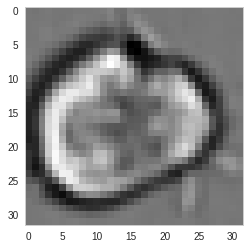

In [60]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(vv[6,:,:,0], cmap='gray')

In [61]:
j = 1
plt.figure(figsize=(12,3))
run_list = list()
for i in sdict.keys():
    sess, enc, sdd, loss, images = get_network(i, sdict[i][1], sdict[i][0])
    bn, r, loss = sess.run([enc, sdd, loss], feed_dict={images:vv})
    run_list.append({'size':i, 'bn':bn, 'rc':r, 'loss':loss})


/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS96/checkpoint-2018-04-25-09-02-40
OK, exists
Encoder False
isize:  4 32
dh0 (?, 32, 32, 4)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS96/checkpoint-2018-04-25-09-02-40/autoencoder-96x-27960
/media/cjw/Data/cyto/Checkpoints/2018-04-25-LS288/checkpoint-2018-04-25-17-34-16
OK, exists
Encoder False
isize:  4 32
dh0 (?, 32, 32, 4)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-25-LS288/checkpoint-2018-04-25-17-34-16/autoencoder-288x-27960
/media/cjw/Data/cyto/Checkpoints/2018-04-26-LS384/checkpoint-2018-04-26-14-49-19
OK, exists
Encoder False
isize:  4 32
dh0 (?, 32, 32, 4)
Tensor("Mean_1:0", shape=(), dtype=

In [62]:
sizes = sorted([k['size'] for k in run_list])

In [63]:
sizes

[32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 512]

32 4.65626
64 3.61177
96 3.14082
128 2.96007
160 2.48351
192 2.45256
224 2.82269
256 2.30744
288 2.10366
320 2.04224
352 2.0335
384 1.91995
512 1.82298


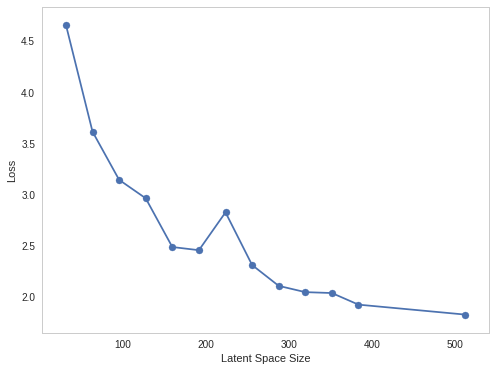

In [113]:
sns.set_style("whitegrid", {'axes.grid' : False})
losses = list()
for size in sizes:
    run_ =[k for k in run_list if k['size'] == size]
    run = run_[0]
    print(run['size'], run['loss'])
    #print(run['rc'].shape)
    losses.append(run['loss'])
    
plt.figure(figsize=(8,6))
plt.plot(sizes, losses)
plt.scatter(sizes, losses)
plt.xlabel("Latent Space Size")
plt.ylabel("Loss")
plt.savefig("/media/cjw/size_vs_loss.pdf")

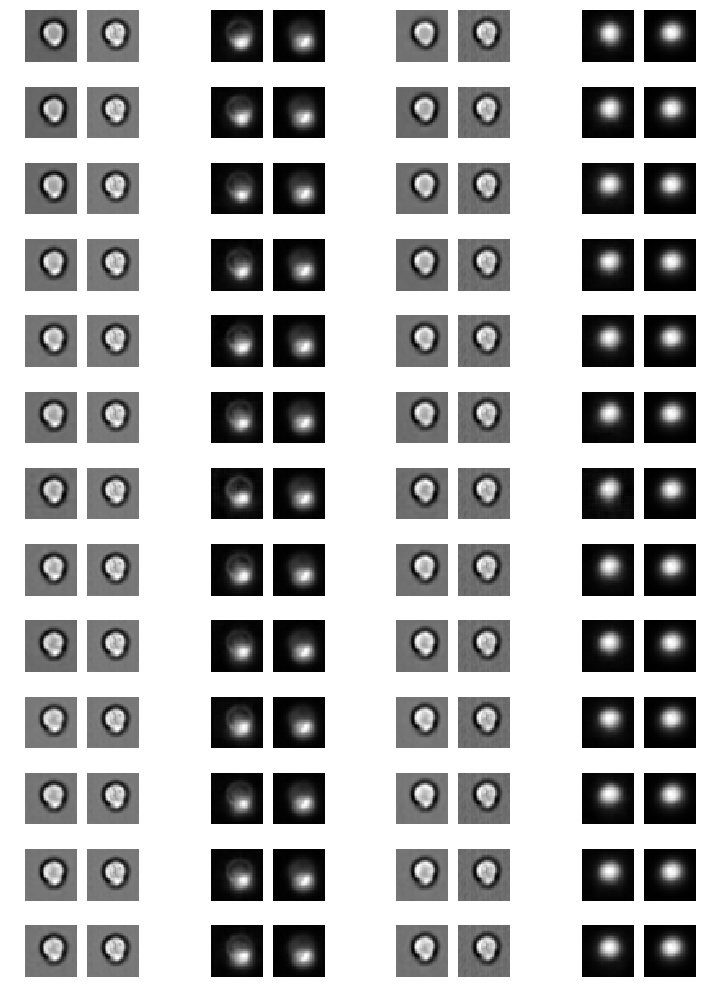

In [132]:
plt.figure(figsize=(12,18))

ip = 1
np = len(sizes)
for size in sizes:
#     if size != 256:
#         continue
#     print(size)
    run_ =[k for k in run_list if k['size'] == size]
    run = run_[0]
    g = run['rc']
    #print(g.shape)
    for i in [4]:
        for c in range(4):
            if c > 0:
                ip += 1
            plt.subplot(np, 11, ip)
            ip += 1
            plt.imshow(g[i,:,:, c], cmap='gray')
            plt.axis('off')
            plt.subplot(np, 11, ip)
            plt.imshow(vv[i,:,:, c], cmap='gray')
            plt.axis('off')
            ip += 1
            
plt.savefig("/media/cjw/reconstruction_by_size_4.pdf")
            

In [129]:
run_['rc'].shape

TypeError: list indices must be integers or slices, not str